# Gradient Boosting Model

HistGradientBoostingClassifier baseline with cross-validation and holdout evaluation on the Grand Prix dataset.


In [9]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display


In [10]:
DATA_PATH = Path('data/grandprix_features_2.csv')
FEATURES = ['year', 'round', 'avg_race_lap_time_s', 'quali_position', 'prev_points_total']
TARGET = 'scored_points'
RANDOM_STATE = 42


In [11]:
# Load data
df = pd.read_csv(DATA_PATH)
print(f'Rows: {len(df)}')
print(df.head())

X = df[FEATURES]
y = df[TARGET].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print('Train/Test shapes:', X_train.shape, X_test.shape)


Rows: 1560
   year  round                event driver      team  quali_position  \
0  2020      1  Austrian Grand Prix    BOT  Mercedes             1.0   
1  2020      1  Austrian Grand Prix    LEC   Ferrari             7.0   
2  2020      1  Austrian Grand Prix    NOR   McLaren             4.0   
3  2020      1  Austrian Grand Prix    HAM  Mercedes             2.0   
4  2020      1  Austrian Grand Prix    SAI   McLaren             8.0   

   avg_race_lap_time_s  finish_position  points_awarded  prev_points_total  \
0            68.851635              1.0            25.0                0.0   
1            69.497360              2.0            18.0                0.0   
2            69.444060              3.0            16.0                0.0   
3            68.789760              4.0            12.0                0.0   
4            69.676180              5.0            10.0                0.0   

   scored_points  
0              1  
1              1  
2              1  
3          

Pipeline: Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(learning_rate=0.05, max_depth=5,
                                                max_iter=400,
                                                random_state=42))])
CV ROC-AUC: 0.836 ± 0.035
CV PR-AUC (avg precision): 0.815 ± 0.040
Holdout classification report:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       156
           1       0.79      0.87      0.83       156

    accuracy                           0.82       312
   macro avg       0.82      0.82      0.82       312
weighted avg       0.82      0.82      0.82       312

Holdout ROC-AUC: 0.8577005259697568
Holdout PR-AUC (avg precision): 0.8270566236693233
Additional metrics:
Precision: 0.7894736842105263
Recall: 0.8653846153846154
F1 (binary): 0.8256880733944955
F1 (macro): 0.8168844407376518
Confusi

,Pred 0,Pred 1
Actual 0,120,36
Actual 1,21,135


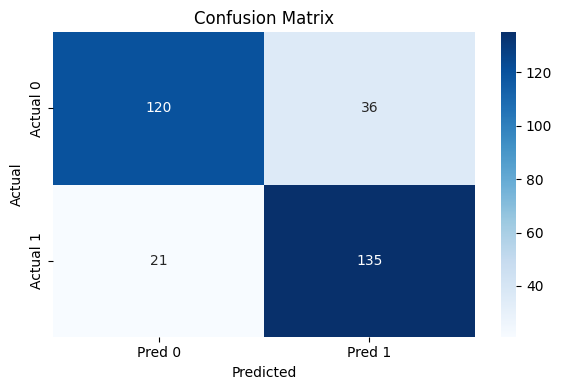

In [12]:
# HistGradientBoosting pipeline
hgb = make_pipeline(
    SimpleImputer(strategy='median'),
    HistGradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.05,
        max_depth=5,
        max_iter=400,
        random_state=RANDOM_STATE,
    ),
)
print('Pipeline:', hgb)

# Cross-validation
cv_auc = cross_val_score(hgb, X_train, y_train, cv=5, scoring='roc_auc')
cv_pr = cross_val_score(hgb, X_train, y_train, cv=5, scoring='average_precision')
print(f'CV ROC-AUC: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}')
print(f'CV PR-AUC (avg precision): {cv_pr.mean():.3f} ± {cv_pr.std():.3f}')

# Fit on training data
hgb.fit(X_train, y_train)

y_pred = hgb.predict(X_test)
y_proba = hgb.predict_proba(X_test)[:, 1]

# Holdout evaluation
print('Holdout classification report:')
print(classification_report(y_test, y_pred))
print('Holdout ROC-AUC:', roc_auc_score(y_test, y_proba))
print('Holdout PR-AUC (avg precision):', average_precision_score(y_test, y_proba))
print('Additional metrics:')
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 (binary):', f1_score(y_test, y_pred))
print('F1 (macro):', f1_score(y_test, y_pred, average='macro'))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix (raw):', cm)

cm_df = pd.DataFrame(
    cm,
    index=[f'Actual {i}' for i in range(cm.shape[0])],
    columns=[f'Pred {i}' for i in range(cm.shape[1])],
)
print('Confusion matrix as table:')
display(cm_df)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
